In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from Deep_Learning.Representation_Learning.BYOL.model import Model
from Deep_Learning.Representation_Learning.BYOL.train import train

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

  0%|          | 0/48000 [00:00<?, ?it/s]

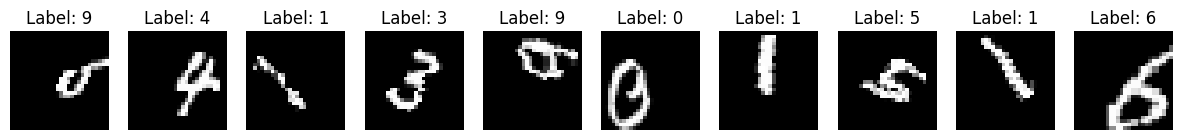

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

train_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform()
])

augmentation = transforms.Compose([
    transforms.RandomApply([transforms.RandomAffine(degrees=180)], p=0.75),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.286, 0))], p=0.75),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0, 0.286))], p=0.75),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, scale=(0.75, 1.25))], p=0.75),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, shear=25)], p=0.75),
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    img = augmentation(img)
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

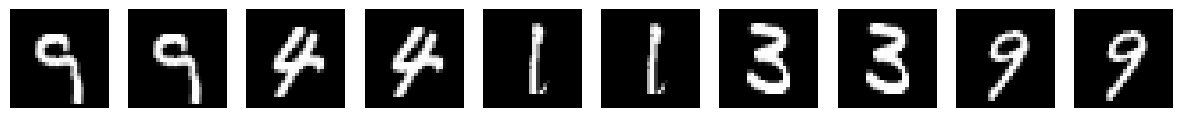

In [4]:
images = train_set.transformed_images[:5]
images = torch.cat([images, images], dim=1).view(-1, 1, 28, 28).contiguous()

fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

In [8]:
model_name = 'BYOL-0.001-BS256'
log_dir = f'Deep_Learning/Representation_Learning/logs/{model_name}'
save_dir = f'Deep_Learning/Representation_Learning/BYOL/models/{model_name}.pth'
# log_dir = None
# save_dir = None
writer = None
if log_dir is not None:
    writer = SummaryWriter(log_dir)
model = Model(in_features=1).to(device)

In [9]:
to_train = True
if save_dir is not None:
    try:
        model.load_state_dict(torch.load(save_dir))
        to_train = False
    except FileNotFoundError:
        pass
        print('Model not found, training new model')
if to_train:
    train(
        model,
        train_set,
        val_set,
        num_epochs=500,
        batch_size=256,
        lr=0.001,
        wd=1.5e-6,
        augmentation=augmentation,
        writer=writer,
        save_dir=save_dir,
        save_every=5,
    )

Model not found, training new model


Loading Best Model


In [ ]:
print("Loading Best Model")
if save_dir is not None:
    try:
        model.load_state_dict(torch.load(save_dir))
    except FileNotFoundError:
        print('Model not found')

In [11]:
classifier = nn.Linear(512, 10).to(device)

num_epochs = 100
batch_size = 1000
lr = 0.01
optimiser = torch.optim.AdamW(classifier.parameters(), lr=lr)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
scaler = torch.cuda.amp.GradScaler()

last_train_loss = torch.tensor(-1, device=device) 
last_train_acc = torch.tensor(-1, device=device)
last_val_loss = torch.tensor(-1, device=device)
last_val_acc = torch.tensor(-1, device=device)

postfix = {}
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    loop.set_description(f'Epoch [{epoch}/{num_epochs}]')
    if epoch > 0:
        loop.set_postfix(postfix)
    epoch_train_loss = torch.zeros(len(train_loader), device=device)
    epoch_train_acc = torch.zeros(len(train_loader), device=device)
    for i, (x, y) in loop:
        with torch.cuda.amp.autocast():
            with torch.no_grad():
                x = model(x)
            y_pred = classifier(x)
            loss = F.cross_entropy(y_pred, y)
        optimiser.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimiser)
        scaler.update()

        epoch_train_loss[i] = loss.detach()
        epoch_train_acc[i] = (y_pred.argmax(dim=1) == y).float().mean().detach()

    last_train_loss = epoch_train_loss.mean()
    last_train_acc = epoch_train_acc.mean()
    
    with torch.no_grad():
        epoch_val_loss = torch.zeros(len(val_loader), device=device) 
        epoch_val_acc = torch.zeros(len(val_loader), device=device)
        for i, (x, y) in enumerate(val_loader):
            with torch.cuda.amp.autocast():
                x = model(x)
                y_pred = classifier(x)
                loss = F.cross_entropy(y_pred, y)
            epoch_val_loss[i] = loss.detach()
            epoch_val_acc[i] =  (y_pred.argmax(dim=1) == y).float().mean().detach()

    last_val_loss = epoch_val_loss.mean()
    last_val_acc = epoch_val_acc.mean()
    
    if writer is not None:
        writer.add_scalar('Classifier/train_loss', last_train_loss.item(), epoch)
        writer.add_scalar('Classifier/train_acc', last_train_acc.item(), epoch)
        writer.add_scalar('Classifier/val_loss', last_val_loss.item(), epoch)
        writer.add_scalar('Classifier/val_acc', last_val_acc.item(), epoch)
    postfix = {
        'Train Loss': last_train_loss.item(),
        'Train Acc': last_train_acc.item(),
        'Val Loss': last_val_loss.item(),
        'Val Acc': last_val_acc.item(),
    }
    loop.set_postfix(postfix)
    loop.close()